## Notebook used to make synthetic disease progressions for healthy, LIR & MIR subgroups

In [1]:
# load packages and files
using DifferentialEquations, SciMLBase, Plots, Random # for solving ODEs
using DataFrames
using DataStructures # for the OrderedDict
using LatinHypercubeSampling # for the LHS
using Trapz # for the trapezoidal rule
using CSV # for reading in the parameter distributions of the Ohashi
using Statistics # for the mean and std functions
using JLD2 # for saving the results
rng_test =  Random.seed!(123456) # testing
rng_training = Random.seed!(4) # training
save_boolean = false # for saving the results


include("../EDES/including.jl") # for the EDES model 
include("../DataGeneration/AnalyseSynths/SyntheticPatients.jl") # for generating initial states of the synthetic patients
include("../DataGeneration/AnalyseSynths/LocalSensitivity.jl") # for the local sensitivity analysis
include("MIRLIR_progression.jl") # for the MIRLIR disease trajectories
include("../DataGeneration/AnalyseSynths/Realism_inital.jl") # for the analysis of the synthetic patients


ensure_realism_initial (generic function with 3 methods)

In [5]:
# hyperparameters for the data generation
N_training = 100 # number of training patients to start with, will decrease later after checking the realism
N_test = 20 # number of test patients to start with, will decrease later after checking the realism
BW = 70 
spread_percentage = 0.15

# initial parameters for the synthetic population
distributions_ohashi = CSV.read("./PERSON and Ohashi/accepted_df_allOHASHI.csv", DataFrame)
# initial_k1 = mean(distributions_ohashi[!, "k1"])
initial_k1 = 0.0075
initial_k5 = mean(distributions_ohashi[!, "k5"])
initial_k6 = mean(distributions_ohashi[!, "k6"])

# initial parameters for the synthetic population
parameter_names = ["k1","k5", "k6"]
initial_people = [initial_k1, initial_k5, initial_k6]
fasting_range_glucose = (4.8, 5.2)
fasting_range_insulin = (7.5, 12.0)

# standard deviations for the parameters, right now
lower_deviations_initial = initial_people .- (initial_people .* spread_percentage )
upper_deviations_initial = initial_people .+ (initial_people .* spread_percentage )


parameter_ranges_initial= OrderedDict( "k1" => (lower_deviations_initial[1], upper_deviations_initial[1]),
                                    "k5" => (lower_deviations_initial[2], upper_deviations_initial[2]),
                                    "k6" => (lower_deviations_initial[3], upper_deviations_initial[3]),
                                   )
fasting_ranges = OrderedDict("fasting_glucose" => fasting_range_glucose, "fasting_insulin" => fasting_range_insulin)


Synthetic_population_training = MakePatients(N_training, parameter_names, parameter_ranges_initial, fasting_ranges, BW = BW, rng= rng_training);
Synthetic_population_test = MakePatients(N_test, parameter_names, parameter_ranges_initial, fasting_ranges, BW = BW, rng= rng_test);

Note here that the starting values of some parameters change in the progressions, so these are with low k3,k4 etc. so are gonna be different from the first measurement in the progression

### Generate individuals progression

In [6]:
training_data = Synthetic_population_training
test_data = Synthetic_population_test

# Set hyperparameters for the MIR LIR progression
long_time_points = [0,6,12,18,24,30]
noise_level = 0.05 # 10% noise in the value of the parameters

# Initialise the progression lists
training_progressions = []
test_progressions = []

# Process training data
for (i, patient) in enumerate(training_data)

    k3s_patient, k4s_patient, k5s_patient ,G_liv_b_patient, fasting_glucose, fasting_insulin = Healthy_progression(
    patient, long_time_points,  noise_level)

    
    
    param_names = ["k1", "k3", "k4", "k5", "k6", "G_liv_b"]
    k1s = fill(patient.ParameterValues[1], length(long_time_points))
    k6s = fill(patient.ParameterValues[3], length(long_time_points))
    
    param_values = permutedims(hcat(k1s, k3s_patient, k4s_patient, k5s_patient, k6s, G_liv_b_patient))
    synthetic_progression = SyntheticProgression(patient, long_time_points, param_names, param_values, fasting_glucose, fasting_insulin)
    push!(training_progressions, synthetic_progression)
end

# Process test data
for (i, patient) in enumerate(test_data)
    
    k3s_patient, k4s_patient, k5s_patient,G_liv_b_patient, fasting_glucose, fasting_insulin = Healthy_progression(
    patient, long_time_points,  noise_level)

    
    
    param_names = ["k1", "k3", "k4", "k5", "k6", "G_liv_b"]
    k1s = fill(patient.ParameterValues[1], length(long_time_points))
    k6s = fill(patient.ParameterValues[3], length(long_time_points))
    
    param_values = permutedims(hcat(k1s, k3s_patient, k4s_patient, k5s_patient, k6s, G_liv_b_patient))
    synthetic_progression = SyntheticProgression(patient, long_time_points, param_names, param_values, fasting_glucose, fasting_insulin)
    push!(test_progressions, synthetic_progression)
end


### visualise some responses


┌ Warning: Mutation of ODEProblem detected. SciMLBase v2.0 has made ODEProblem temporarily mutable in order to allow for interfacing with EnzymeRules due to a current limitation in the rule system. This change is only intended to be temporary and ODEProblem will return to being a struct in a later non-breaking release. Do not rely on this behavior, use with caution.
└ @ SciMLBase C:\Users\20192809\.julia\packages\SciMLBase\Dwomw\src\problems\ode_problems.jl:168
┌ Warning: Mutation of ODEProblem detected. SciMLBase v2.0 has made ODEProblem temporarily mutable in order to allow for interfacing with EnzymeRules due to a current limitation in the rule system. This change is only intended to be temporary and ODEProblem will return to being a struct in a later non-breaking release. Do not rely on this behavior, use with caution.
└ @ SciMLBase C:\Users\20192809\.julia\packages\SciMLBase\Dwomw\src\problems\ode_problems.jl:168
┌ Warning: Mutation of ODEProblem detected. SciMLBase v2.0 has made 

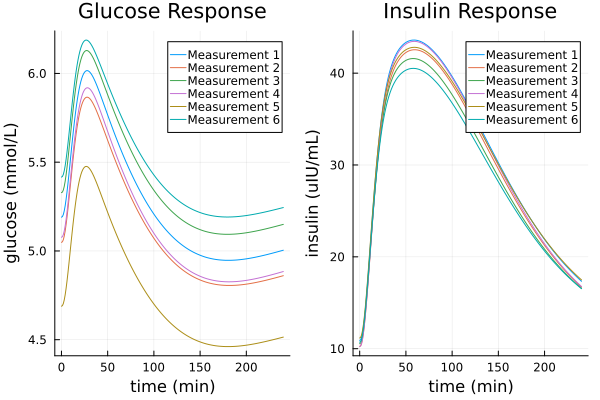

In [7]:
# load the training progressions
# training_progressions = JLD2.load("Metadata/Training_progressions.jld2")["training_progressions"];
# select the first progression
progression =  training_progressions[3]
model = progression.patient.EDES

# plot the meal response
PlotMealResponseProgression(model, progression.parameter_names, progression.parameter_values[:,1:6], progression.fasting_glucose, progression.fasting_insulin)
# progression.parameter_values[:,1:6]

### Sensitivity analysis

In [5]:
include("../DataGeneration/AnalyseSynths/LocalSensitivity.jl") # for the local sensitivity analysis

param_names = ["k1", "k3", "k4", "k5", "k6", "G_liv_b"]
timepoint = 6
# select the first progression
progression =  training_progressions[1]
patient = progression.patient
param_values = progression.parameter_values[:,timepoint]

# LocalSensitivityAnalysis(patient, param_values, param_names)

6-element Vector{Float64}:
 0.006690000004275
 0.005967747730730223
 0.00022468474004219276
 0.10819141585985877
 2.0417260091637273
 0.04181233249907209

### Sample timepoints from every OGTT

In [6]:
training_data = training_progressions

# hyperparameters
short_time_points = [0,15,30,60,120,180,240]
sampling_noise_glucose = 0.05
sampling_noise_insulin = 0.1
glucose = []
insulin = []

for i in 1:length(training_data)
    # extract relevant information
    progression = training_progressions[i]
    patient = progression.patient
    EDES_model = patient.EDES
    long_time_points = progression.long_time_points
    parameter_names = progression.parameter_names
    glucose_person = []
    insulin_person = []

    # loop over the time points
    for j in 1:length(long_time_points)
        parameter_values = progression.parameter_values[:,j]
        fasting_glucose = progression.fasting_glucose[j]
        fasting_insulin = progression.fasting_insulin[j]

        # reset fasting values (this is not so nice but works, better to rewrite the EDES model so that fasting glucose and insulin are more explicit inputs to ODE)
        EDES_model.prob.u0[2] = fasting_glucose
        EDES_model.prob.u0[4] = fasting_insulin

         # make the parameter vector 
        parameter_vector = make_full_parameter_vector(EDES_model, parameter_names, parameter_values)

        # simulate the data
        simulated_data = output(EDES_model, parameter_vector)
        time = simulated_data.time
        glucose_response = simulated_data.plasma_glucose
        insulin_response = simulated_data.plasma_insulin
        
        # sample the OGTT
        glucose_points = [Float64(glucose_response[findfirst(==(t), time)]) * (1 + sampling_noise_glucose * randn()) for t in short_time_points if t in time]
        insulin_points = [Float64(insulin_response[findfirst(==(t), time)]) * (1 + sampling_noise_insulin * randn()) for t in short_time_points if t in time]
        


        push!(glucose_person, glucose_points)
        push!(insulin_person, insulin_points)
    end
   
    push!(glucose, glucose_person)
    push!(insulin, insulin_person)

end

# convert to a table
glucose_table = reduce(vcat, glucose)  # Ensures consistent dimensions
insulin_table = reduce(vcat, insulin)  # Ensures consistent dimensions
# Convert to DataFrame
glucose_df = DataFrame(glucose_table, :auto);
glucose_df = DataFrame(permutedims(Matrix(glucose_df)), [Symbol("glucose_t_", t) for t in short_time_points])
 
insulin_df = DataFrame(insulin_table, :auto);
insulin_df = DataFrame(permutedims(Matrix(insulin_df)), [Symbol("insulin_t_", t) for t in short_time_points])

OGTT_df_training = hcat(glucose_df, insulin_df)
# Add patient ID
patient_ID_training = [progression.patient.ID for progression in training_data]  # Repeat the patient IDs

# Add long_time_point column
long_time_points_training = vcat([progression.long_time_points for progression in training_data]...)  # Repeat the long time points

# Add the patient ID column to glucose_df
insertcols!(OGTT_df_training, 1, :Patient_ID => repeat(patient_ID_training, inner=length(long_time_points)))
insertcols!(OGTT_df_training, 2, :Long_Time => long_time_points_training);

In [7]:
test_data = test_progressions
sampling_noise_glucose = 0.05
sampling_noise_insulin = 0.1
glucose = []
insulin = []

for i in 1:length(test_data)
    # extract relevant information
    progression = test_data[i]
    patient = progression.patient
    EDES_model = patient.EDES
    long_time_points = progression.long_time_points
    parameter_names = progression.parameter_names
    glucose_person = []
    insulin_person = []

    # loop over the time points
    for j in 1:length(long_time_points)
        parameter_values = progression.parameter_values[:,j]
        fasting_glucose = progression.fasting_glucose[j]
        fasting_insulin = progression.fasting_insulin[j]

        # reset fasting values (this is not so nice but works, better to rewrite the EDES model so that fasting glucose and insulin are more explicit inputs to ODE)
        EDES_model.prob.u0[2] = fasting_glucose
        EDES_model.prob.u0[4] = fasting_insulin

         # make the parameter vector 
        parameter_vector = make_full_parameter_vector(EDES_model, parameter_names, parameter_values)

        # simulate the data
        simulated_data = output(EDES_model, parameter_vector)
        time = simulated_data.time
        glucose_response = simulated_data.plasma_glucose
        insulin_response = simulated_data.plasma_insulin

        # sample the OGTT
        glucose_points = [Float64(glucose_response[findfirst(==(t), time)]) * (1 + sampling_noise_glucose * randn()) for t in short_time_points if t in time]
        insulin_points = [Float64(insulin_response[findfirst(==(t), time)]) * (1 + sampling_noise_insulin * randn()) for t in short_time_points if t in time]
        

        push!(glucose_person, glucose_points)
        push!(insulin_person, insulin_points)
    end
   
    push!(glucose, glucose_person)
    push!(insulin, insulin_person)

end

# convert to a table
glucose_table = reduce(vcat, glucose)  # Ensures consistent dimensions
insulin_table = reduce(vcat, insulin)  # Ensures consistent dimensions
# Convert to DataFrame
glucose_df = DataFrame(glucose_table, :auto);
glucose_df = DataFrame(permutedims(Matrix(glucose_df)), [Symbol("glucose_t_", t) for t in short_time_points])
 
insulin_df = DataFrame(insulin_table, :auto);
insulin_df = DataFrame(permutedims(Matrix(insulin_df)), [Symbol("insulin_t_", t) for t in short_time_points])

OGTT_df_test = hcat(glucose_df, insulin_df)
# Add patient ID
patient_ID_test = [progression.patient.ID for progression in test_progressions]  # Repeat the patient IDs

# Add long_time_point column
long_time_points_test= vcat([progression.long_time_points for progression in test_progressions]...)  # Repeat the long time points

# Add the patient ID column to glucose_df
insertcols!(OGTT_df_test, 1, :Patient_ID => repeat(patient_ID_test, inner=length(long_time_points)))
insertcols!(OGTT_df_test, 2, :Long_Time => long_time_points_test);


### Fit the EDES model (healthy version)

In [8]:
using Distributed

n_cores = length(Sys.cpu_info())

# note that this is the same as of the synthetic patients, needs to change if we start changing the weight or the dose
BW = 70 
G_dose::Real = 75000.0
time_G = [0,15,30,60,120,180,240]
time_I = [0,15,30,60,120,180,240]

if nprocs()-1 < n_cores
    addprocs(n_cores-nprocs()+1, exeflags="--project")
end

@everywhere begin
    using DifferentialEquations, SciMLBase, Plots, Random # for solving ODEs
    using Optimization, OptimizationOptimJL, LineSearches # for optimization
    using QuasiMonteCarlo # for LHS
    using Trapz
    include("../EDES/including.jl")
end

columnnames = ["Patient_ID","Long_time_points", "k1","k5","k6"]



patients = [[collect(OGTT_df_training[j,3:9]), collect(OGTT_df_training[j,10:16]), BW, G_dose, time_G, time_I] for j in 1:nrow(OGTT_df_training)]
results_training = pmap(x -> ParameterEstimation(x...), patients)

# close the parallel pool
rmprocs(procs()[2:end])

# add the ID, health status and the long time points to the results
# add the ID, health status and the long time points to the results
for i in 1:length(results_training)
    results_training[i] = [OGTT_df_training[i,1], OGTT_df_training[i,2], results_training[i]...]
end

results_training = DataFrame(reduce(hcat, results_training)', Symbol.(columnnames));
results_training[!, 1] = convert.(Int, results_training[!, 1])
results_training[!, 2] = convert.(Int, results_training[!, 2]);




      From worker 9:	Optimization successful! continuing...
      From worker 5:	Optimization successful! continuing...
      From worker 9:	Parameter estimation done!
      From worker 5:	Parameter estimation done!
      From worker 3:	Optimization successful! continuing...
      From worker 3:	Parameter estimation done!
      From worker 7:	Optimization successful! continuing...
      From worker 7:	Parameter estimation done!
      From worker 4:	Optimization successful! continuing...
      From worker 4:	Parameter estimation done!
      From worker 6:	Optimization successful! continuing...
      From worker 6:	Parameter estimation done!
      From worker 8:	Optimization successful! continuing...
      From worker 8:	Parameter estimation done!
      From worker 2:	Optimization successful! continuing...
      From worker 2:	Parameter estimation done!
      From worker 9:	Optimization successful! continuing...
      From worker 5:	Optimization successful! continuing...
      From worke

600-element Vector{Int64}:
  0
  6
 12
 18
 24
 30
  0
  6
 12
 18
  ⋮
 18
 24
 30
  0
  6
 12
 18
 24
 30

In [19]:
n_cores = length(Sys.cpu_info())

# note that this is the same as of the synthetic patients, needs to change if we start changing the weight or the dose
BW = 70 
G_dose::Real = 75000.0
time_G = [0,15,30,60,120,180,240]
time_I = [0,15,30,60,120,180,240]

if nprocs()-1 < n_cores
    addprocs(n_cores-nprocs()+1, exeflags="--project")
end

@everywhere begin
    using DifferentialEquations, SciMLBase, Plots, Random # for solving ODEs
    using Optimization, OptimizationOptimJL, LineSearches # for optimization
    using QuasiMonteCarlo # for LHS
    using Trapz
    include("../EDES/including.jl")
end

columnnames = ["Patient_ID","Long_time_points","k1","k5","k6"]



patients = [[collect(OGTT_df_test[j,3:9]), collect(OGTT_df_test[j,10:16]), BW, G_dose, time_G, time_I] for j in 1:nrow(OGTT_df_test)]
results_test = pmap(x -> ParameterEstimation(x...), patients)

# close the parallel pool
rmprocs(procs()[2:end])

# add the ID, health status and the long time points to the results_test
for i in 1:length(results_test)
    results_test[i] = [OGTT_df_test[i,1], OGTT_df_test[i,2], results_test[i]...]
end

results_test = DataFrame(reduce(hcat, results_test)', Symbol.(columnnames))
results_test[!, 1] = convert.(Int, results_test[!, 1])
results_test[!, 2] = convert.(Int, results_test[!, 2]);



      From worker 24:	Optimization successful! continuing...
      From worker 24:	Parameter estimation done!
      From worker 22:	Optimization successful! continuing...
      From worker 22:	Parameter estimation done!
      From worker 21:	Optimization successful! continuing...
      From worker 21:	Parameter estimation done!
      From worker 23:	Optimization successful! continuing...
      From worker 23:	Parameter estimation done!
      From worker 19:	Optimization successful! continuing...
      From worker 19:	Parameter estimation done!
      From worker 25:	Optimization successful! continuing...
      From worker 25:	Parameter estimation done!
      From worker 18:	Optimization successful! continuing...
      From worker 18:	Parameter estimation done!
      From worker 24:	Optimization successful! continuing...
      From worker 24:	Parameter estimation done!
      From worker 19:	Optimization successful! continuing...
      From worker 19:	Parameter estimation done!
      From

120-element Vector{Int64}:
  0
  6
 12
 18
 24
 30
  0
  6
 12
 18
  ⋮
 18
 24
 30
  0
  6
 12
 18
 24
 30

### Check realism of fits and select first patients that show realism

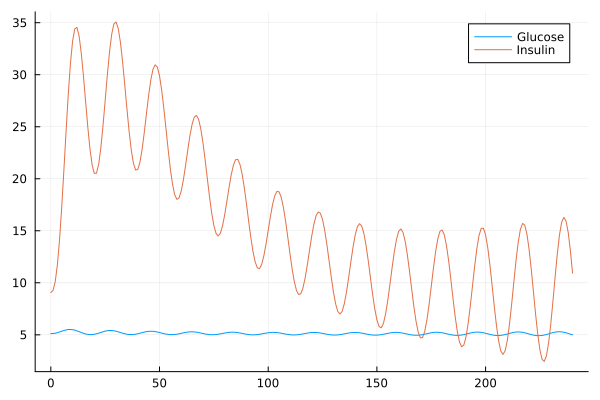

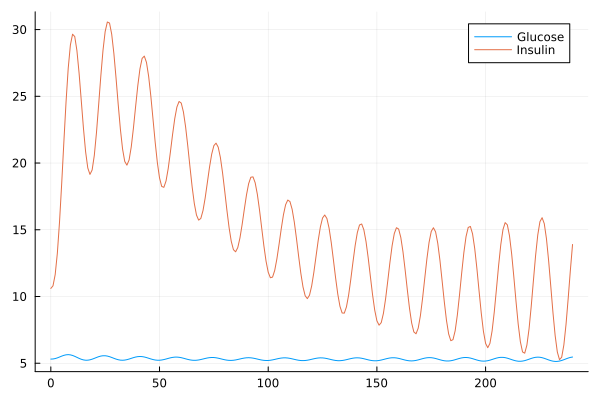

Oscillatory behaviour detected
Oscillatory behaviour detected
Oscillatory behaviour detected
Oscillatory behaviour detected
Oscillatory behaviour detected
Oscillatory behaviour detected


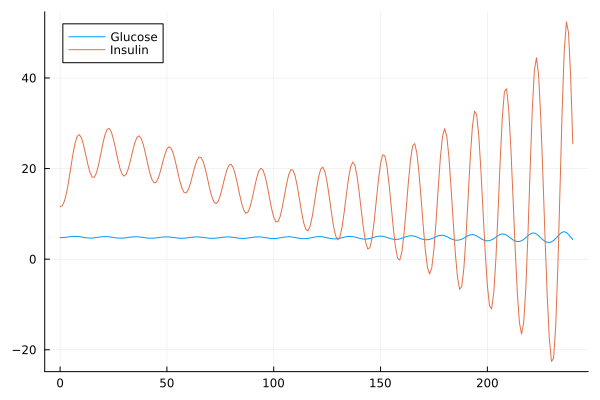

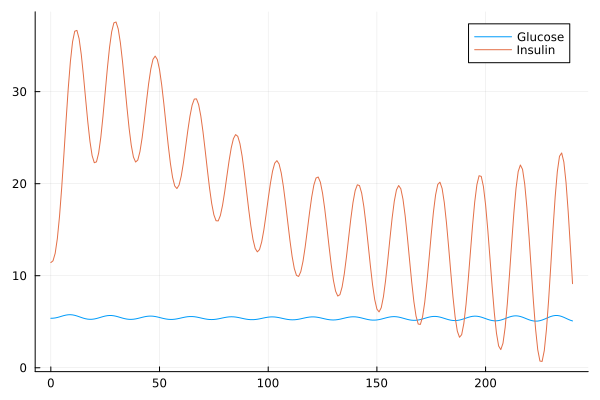

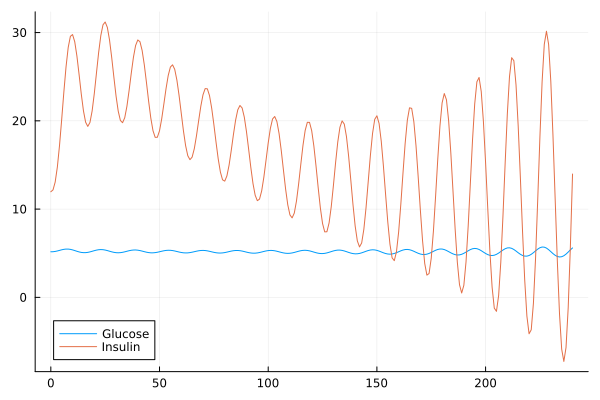

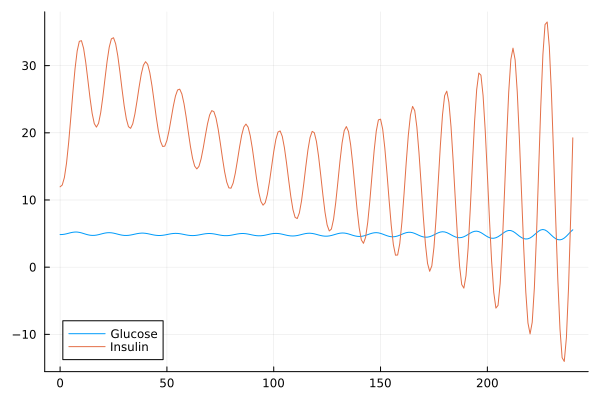

In [20]:
include("./Help functions/Filter_EDES_fits.jl")

# filter the results
filtered_results_training = filter_edes_fits(results_training, OGTT_df_training, max_patients = 50)
filtered_results_test = filter_edes_fits(results_test, OGTT_df_test, max_patients = 10);

In [22]:
# save as a CSV file
if save_boolean
    CSV.write("./Metadata/Training_healthy_EDES_fits.csv", filtered_results_training)
    CSV.write("./Metadata/Test_healthy_EDES_fits.csv", filtered_results_test)
end


# save the OGTT data of the filtered results 
if save_boolean 
    CSV.write("./Metadata/Training_healthy_OGTT.csv", filter(row -> row[:Patient_ID] in unique(filtered_results_training[!, :Patient_ID]), OGTT_df_training))
    CSV.write("./Metadata/Test_healthy_OGTT.csv", filter(row -> row[:Patient_ID] in unique(filtered_results_test[!, :Patient_ID]), OGTT_df_test))
end

"./Metadata/Test_healthy_OGTT.csv"